In [14]:
# Importações
import pandas as pd
import numpy as np
import requests as rq
import zipfile
import datetime
import io
import os
import matplotlib.pyplot as plt

In [15]:
# Atribuições iniciais

# URL do arquivo zip que você deseja baixar
url = 'https://portaldatransparencia.gov.br/download-de-dados/emendas-parlamentares/UNICO'

headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
            'Referer': f"{url}"
}

pd.set_option('display.float_format', lambda x: '%.2f' % x)

data = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

name_directory = f"Emenda_Parlamentar_{data.split(' ')[0].replace('-','')}"

if not os.path.exists(name_directory):
    os.makedirs(name_directory)

response = rq.get(url, headers=headers)

In [16]:
# Extraindo arquivos do zip e inserindo no diretório desejado
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            #zip_ref.extractall(path=namedirectory)
            zip_ref.extractall(path=name_directory)

In [17]:
# Lendo arquivo CSV usando pd.read_csv
df_csv = pd.read_csv(f'{name_directory}/Emendas.csv', sep=';', encoding='ISO-8859-1')

In [18]:
# Ajustando os tipos das colunas e seus valores
df_csv['Ano da Emenda'] = df_csv['Ano da Emenda'].astype(int)
df_csv['Valor Empenhado'] = df_csv['Valor Empenhado'].str.replace(',', '.').astype(float)

   Ano da Emenda  Valor Empenhado
0           2014    6094305555.29
1           2015    3383460923.45
2           2016   25921956417.09
3           2017   17531936593.39
4           2018   12011002555.81
5           2019   13863064452.72
6           2020   37540725479.42
7           2021   33398615010.67
8           2022   25403370096.60
9           2023   23730152113.53


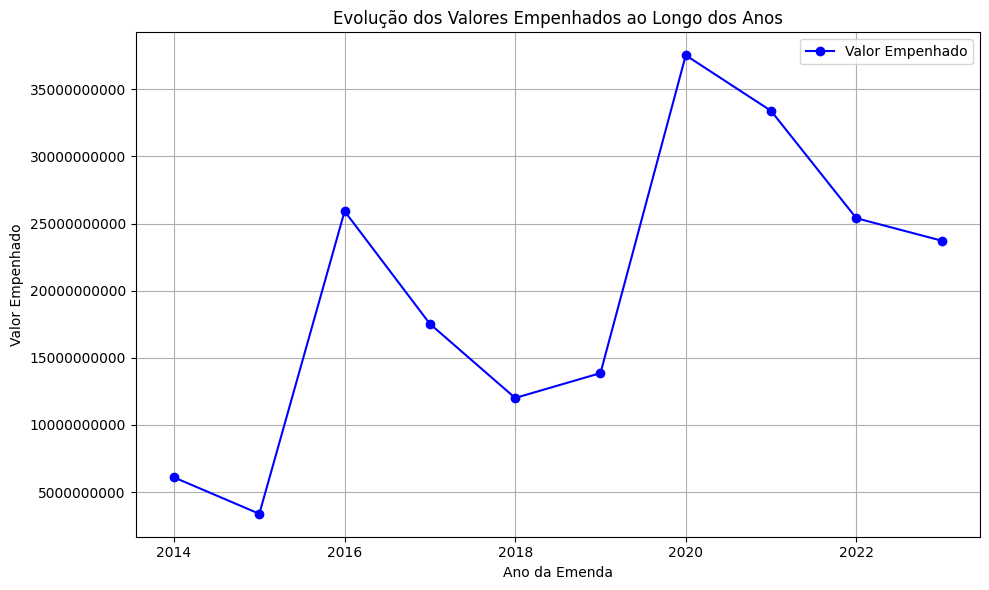

In [19]:
# Evolução anual dos valores empenhados (âmbito geral)
valor_empenhado_agrupado = df_csv.groupby('Ano da Emenda')['Valor Empenhado'].sum()
df_evolucao_empenhados = pd.DataFrame({'Ano da Emenda': valor_empenhado_agrupado.index, 'Valor Empenhado': valor_empenhado_agrupado.values})
#print(df_evolucao_empenhados)

# Agora, você pode criar o gráfico
plt.figure(figsize=(10, 6))  # Define o tamanho do gráfico

# Plota os dados
plt.plot(df_evolucao_empenhados['Ano da Emenda'], df_evolucao_empenhados['Valor Empenhado'], marker='o', color='b', label='Valor Empenhado')

# Adiciona rótulos aos eixos e um título ao gráfico
plt.xlabel('Ano da Emenda')
plt.ylabel('Valor Empenhado')
plt.title('Evolução dos Valores Empenhados ao Longo dos Anos')

# Adiciona uma legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.grid(True)  # Adiciona uma grade ao gráfico (opcional)

plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig(f"{name_directory}/Evolucao_Empenhados_Anual.png")
plt.show()

     Ano da Emenda           Nome Função  Contagem
0             2014                 Saúde       712
1             2014             Urbanismo       245
2             2014              Educação       161
3             2014      Desporto e lazer       147
4             2014           Agricultura       125
..             ...                   ...       ...
229           2023  Ciência e Tecnologia        14
230           2023          Comunicações        13
231           2023   Relações exteriores         4
232           2023             Indústria         3
233           2023         Administração         2

[234 rows x 3 columns]


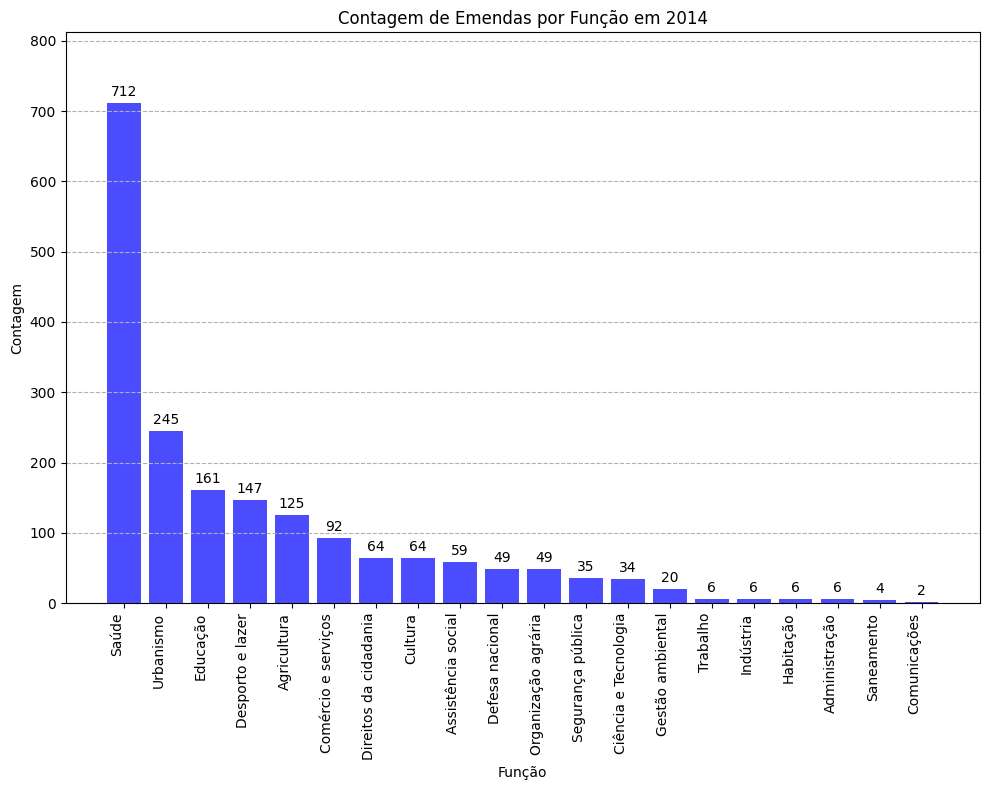

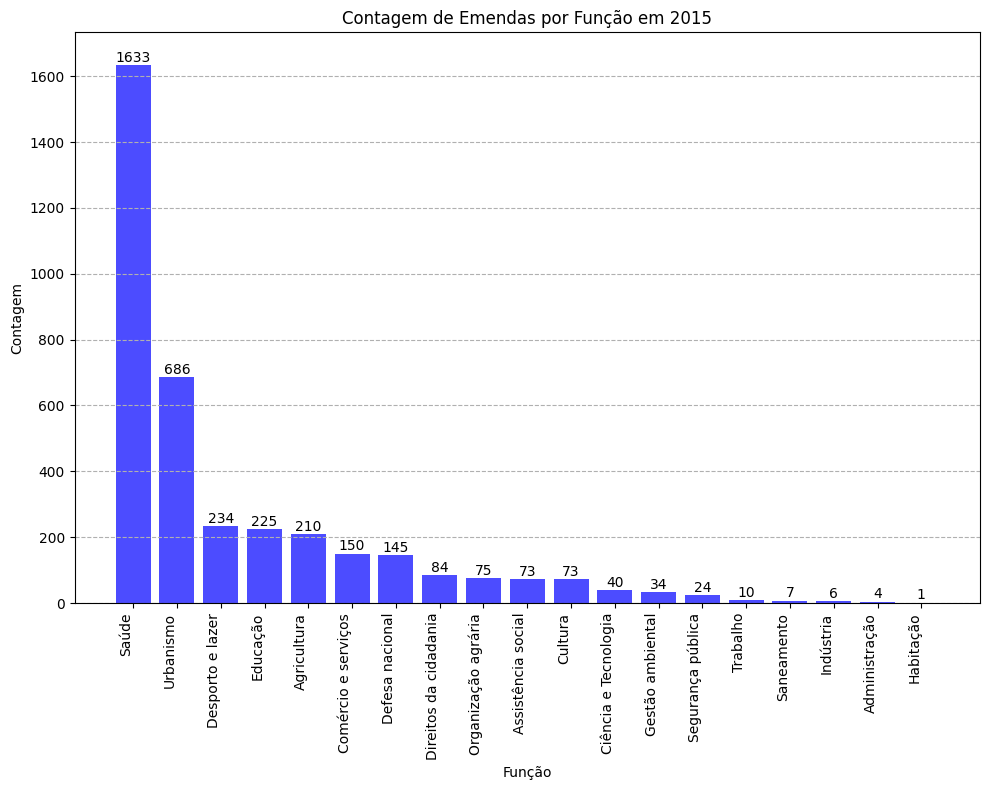

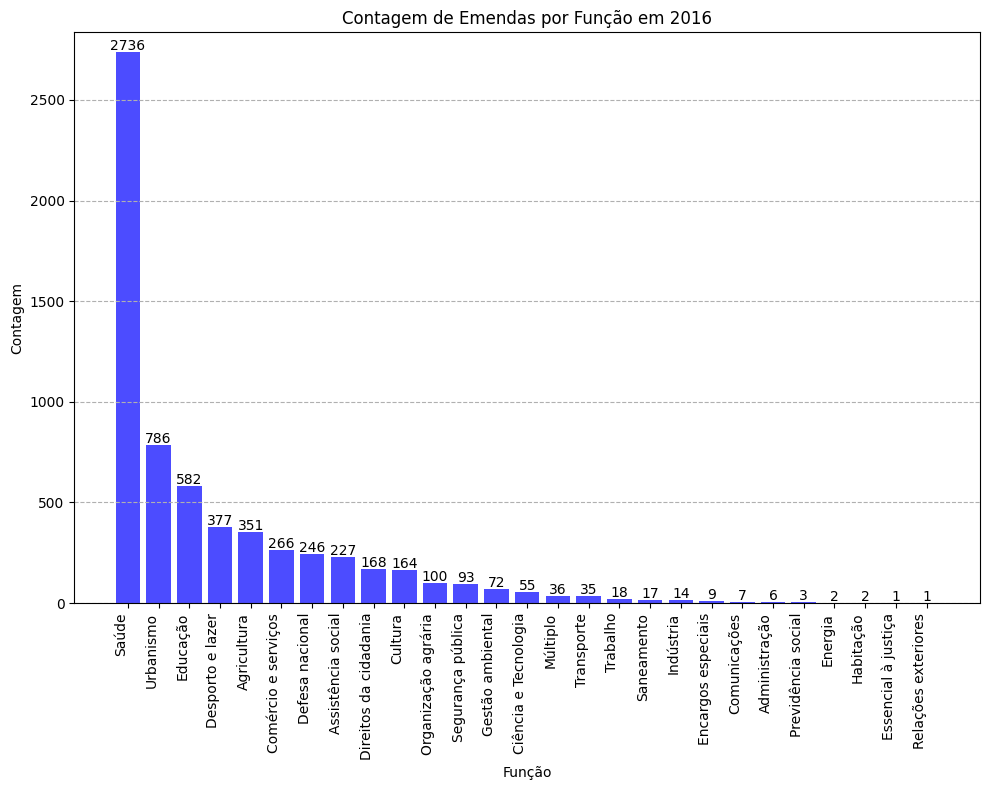

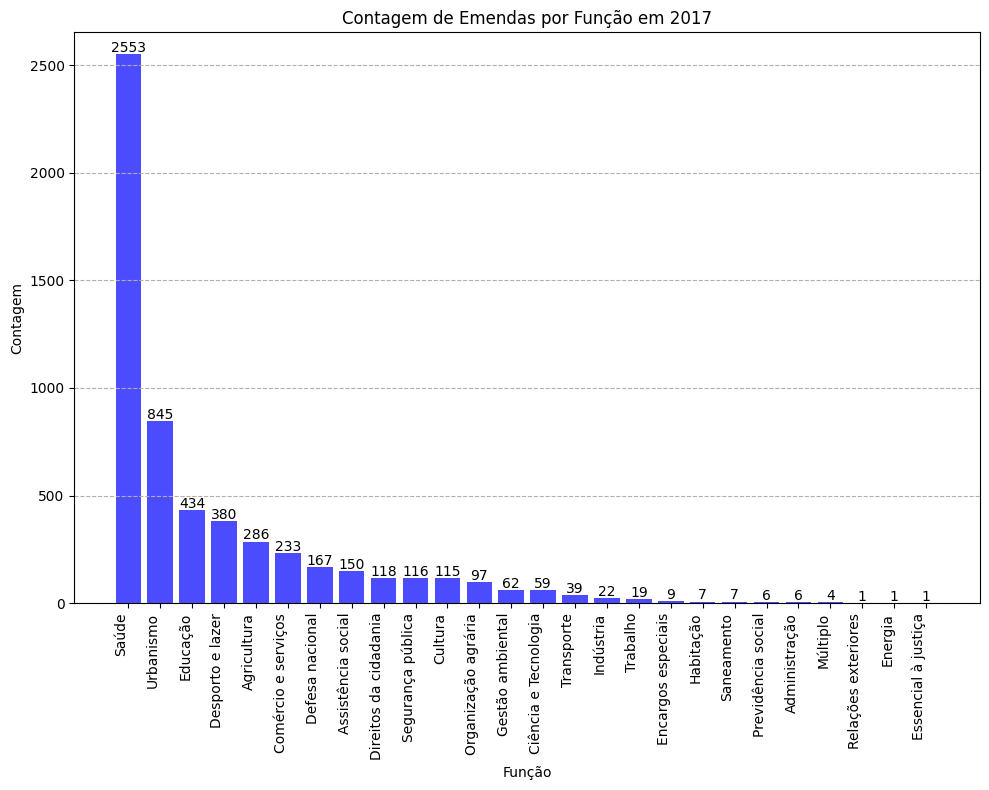

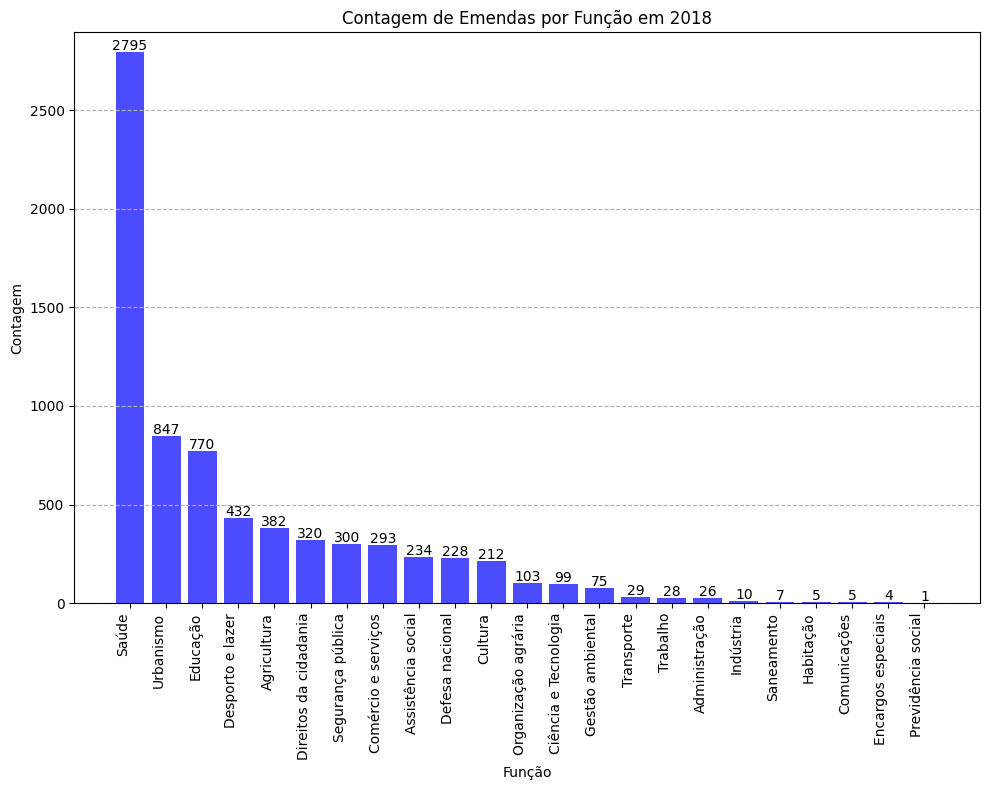

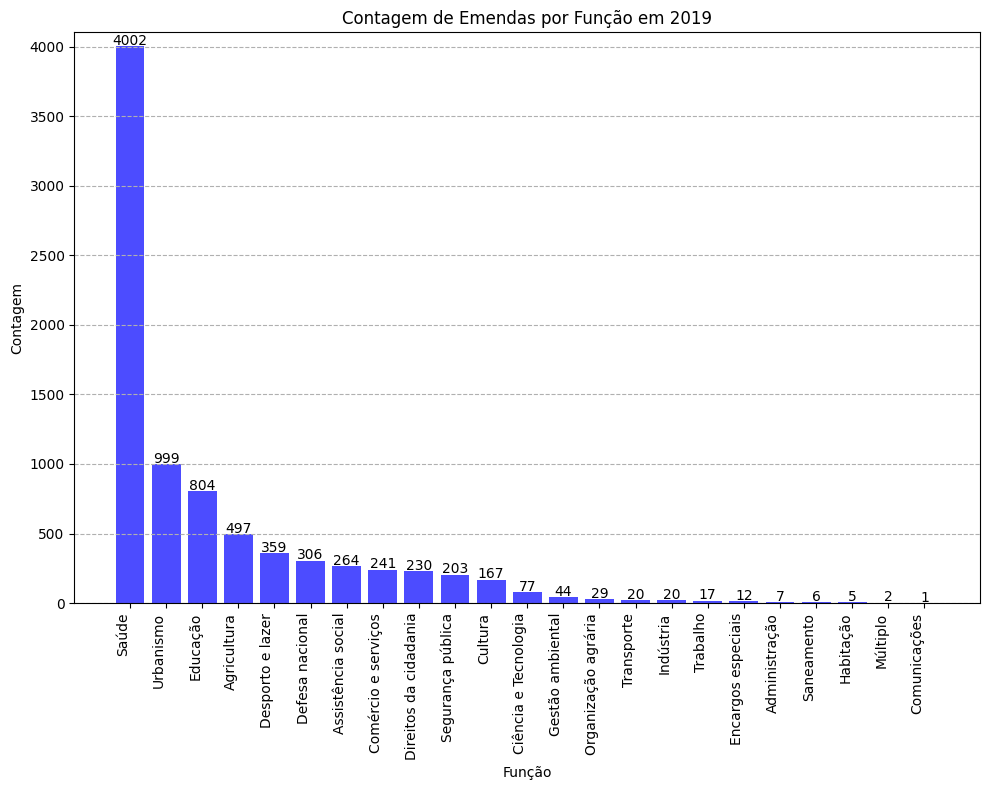

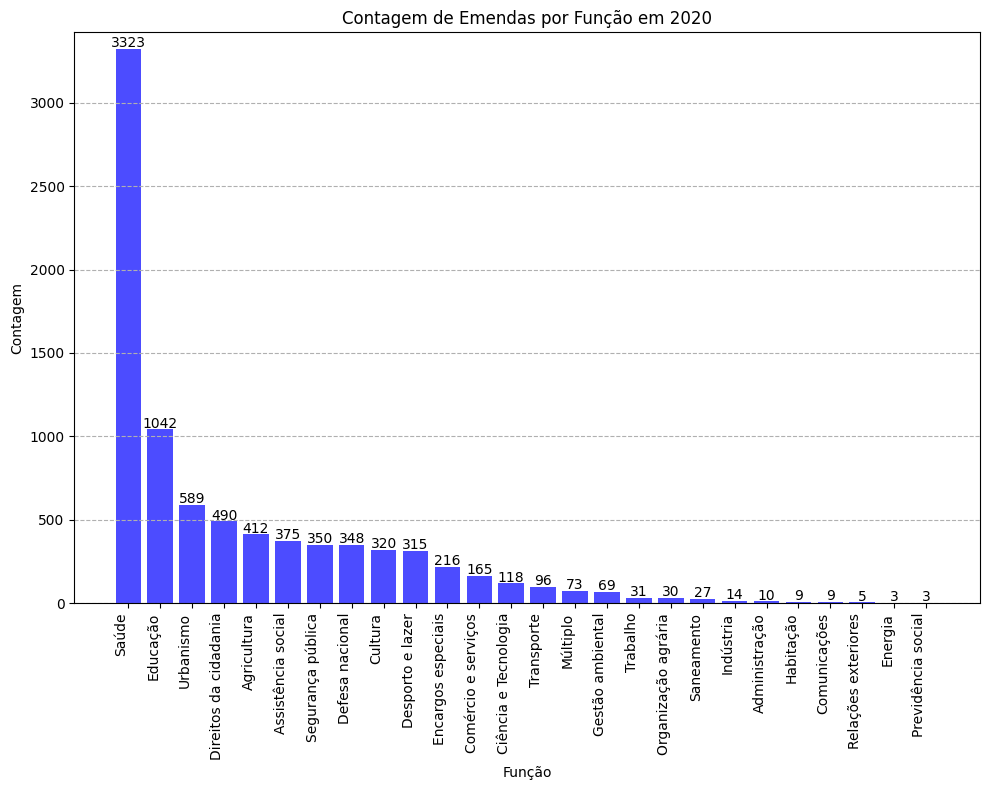

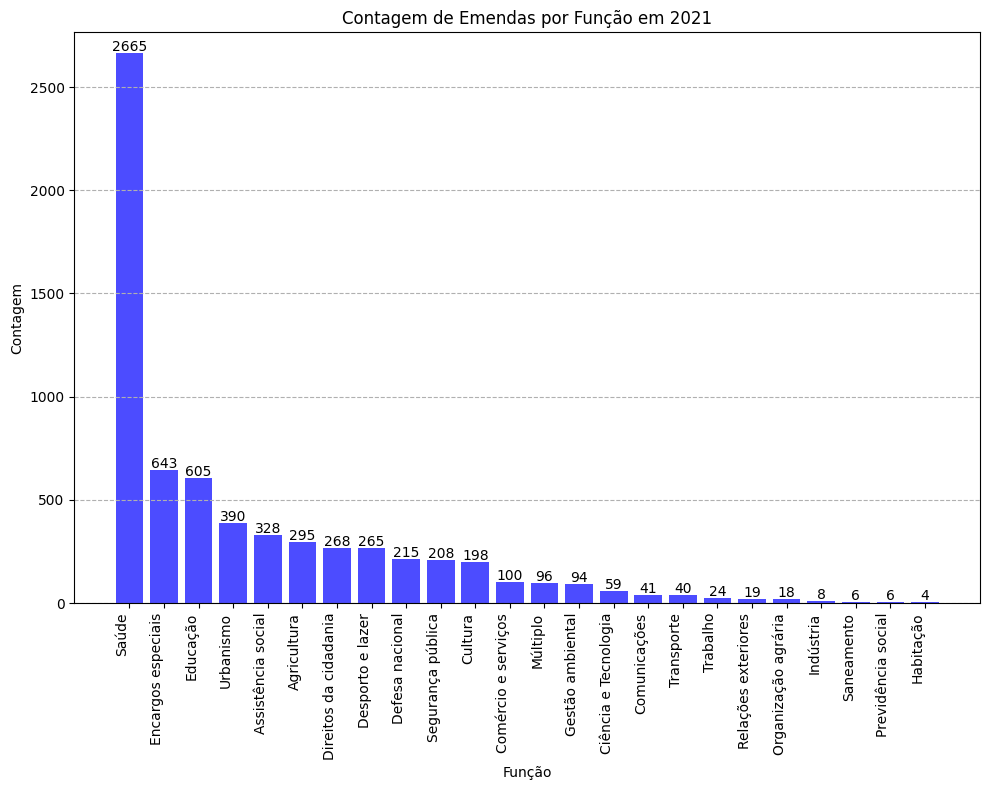

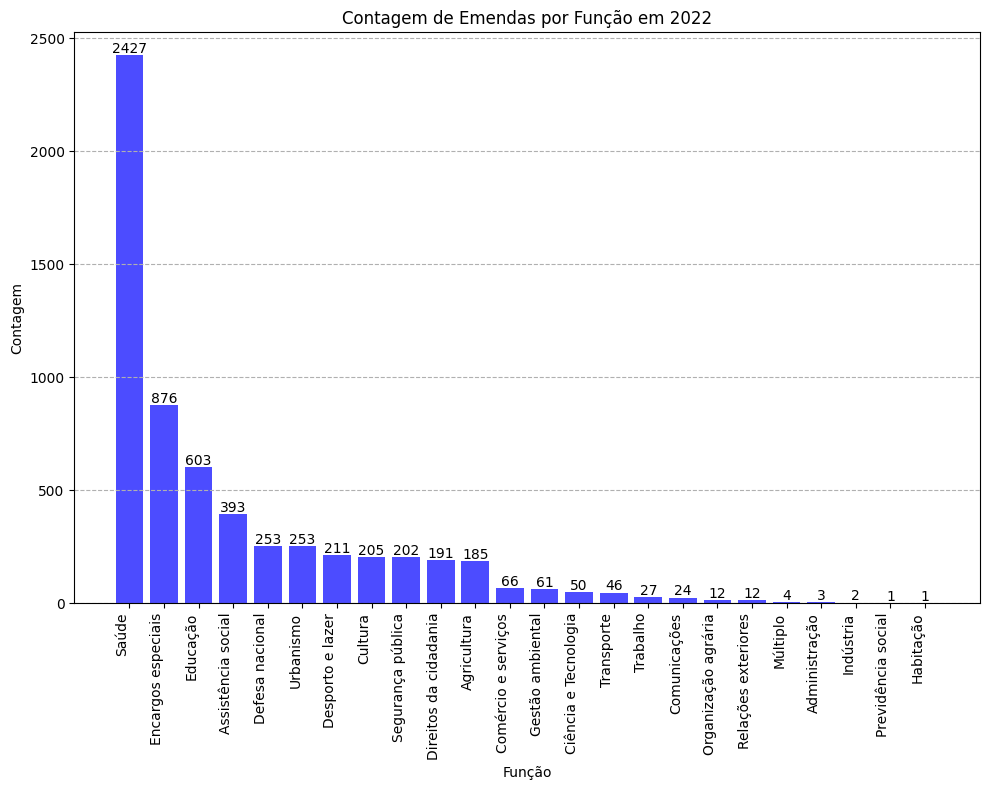

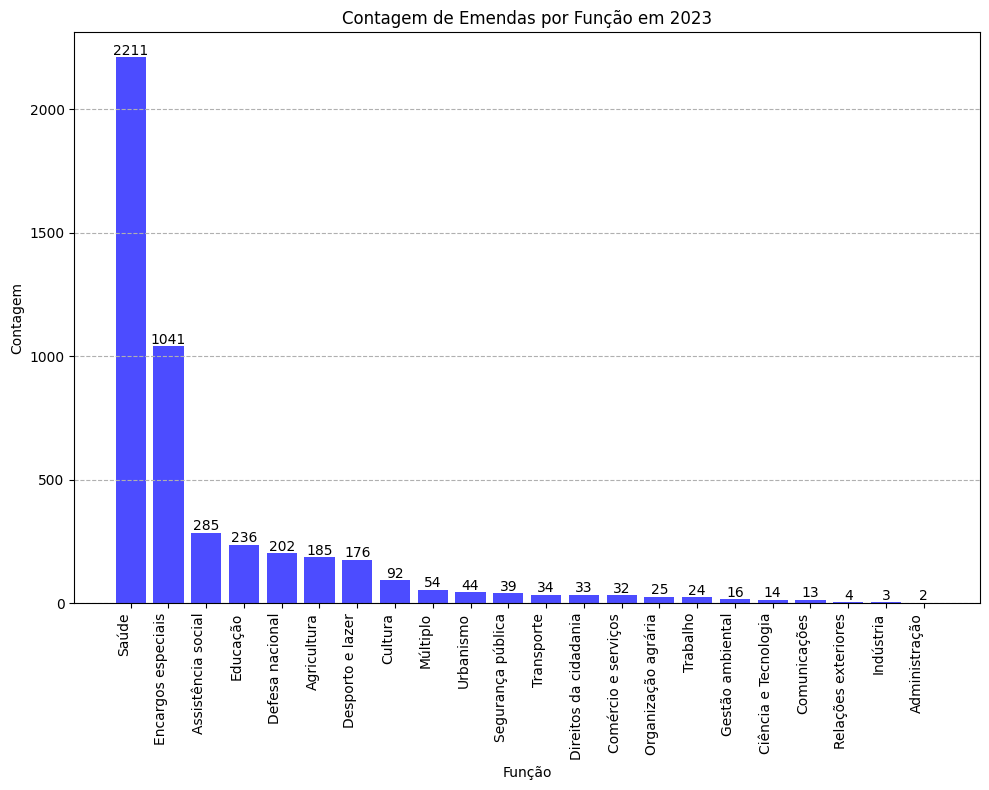

In [36]:
# Ordenação dos setores mais "amparados"
resultados_anual = df_csv.groupby('Ano da Emenda')['Nome Função'].value_counts()
resultados_anual = resultados_anual.reset_index(name='Contagem')
#print(resultados_anual)
resultados_anual_aux = resultados_anual.copy()

for ano in list(resultados_anual['Ano da Emenda'].unique()):
    resultados_anual_aux = resultados_anual[resultados_anual['Ano da Emenda'] == ano]
    plt.figure(figsize=(10, 8))
    plt.bar(range(len(resultados_anual_aux['Nome Função'])), resultados_anual_aux['Contagem'], align='center', alpha=0.7, color='b')
    plt.xlabel('Função')
    plt.ylabel('Contagem')
    plt.title(f'Contagem de Emendas por Função em {ano}')
    plt.xticks(range(len(resultados_anual_aux['Nome Função'])), resultados_anual_aux['Nome Função'])
    plt.xticks(range(len(resultados_anual_aux['Nome Função'])), resultados_anual_aux['Nome Função'], rotation=90, ha='right')  # Rótulos rotacionados
    plt.ylim(0, max(resultados_anual_aux['Contagem']) + 100)  # Ajusta o limite superior do eixo y para melhor visualização

    # Adiciona rótulos nas barras
    for i, v in enumerate(resultados_anual_aux['Contagem']):
        plt.text(i, v + 10, str(v), ha='center')

    plt.grid(axis='y', linestyle='--', alpha=1)
    plt.tight_layout()
    plt.savefig(f"{name_directory}/Setores_Destacados_Anual_{ano}.png")
    plt.show()

In [39]:
# Qual setor, a cada ano, se destaca mais
setor_destaque = resultados_anual.groupby('Ano da Emenda')['Contagem'].idxmax()
filtro_setor_destaque = resultados_anual.loc[setor_destaque]
#print(filtro_setor_destaque)

KeyError: 1

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# A partir dos setores frequentes, ordene os subsetores, dos mais "acessados"
filtro_setores_frequentes = df_csv[(df_csv['Ano da Emenda'].isin(filtro_setor_destaque['Ano da Emenda'])) & (df_csv['Nome Função'].isin(filtro_setor_destaque['Nome Função']))]
contagem_subfuncao_anual = filtro_setores_frequentes.groupby(['Ano da Emenda', 'Nome Subfunção'])['Nome Subfunção'].count().reset_index(name='Contagem')
print(contagem_subfuncao_anual)

     Ano da Emenda                                    Nome Subfunção  Contagem
0             2014                               Administração geral        79
1             2014             Assistência hospitalar e ambulatorial       317
2             2014                                    Atenção básica       255
3             2014                        Desenvolvimento científico         2
4             2014          Desenvolvimento tecnológico e engenharia         2
..             ...                                               ...       ...
115           2023  Difusão do conhecimento científico e tecnológico         7
116           2023                      Formação de recursos humanos        15
117           2023                                          Múltiplo        30
118           2023                           Saneamento básico rural         1
119           2023                         Vigilância epidemiológica         4

[120 rows x 3 columns]


In [ ]:
# Análise histórica dos mandatos, sinalizando em qual ano (do mandato - levando em conta que, usualmente, há 4) há maiores incidências de gastos. CONTINUAR ESSE AQUI
print(df_evolucao_empenhados)
df_evolucao_empenhados['Ano do Mandato'] = (df_evolucao_empenhados['Ano da Emenda'] - df_evolucao_empenhados['Ano da Emenda'].iloc[0]) % 4

maiores_valores_por_mandato = df_evolucao_empenhados.groupby('Ano do Mandato')['Valor Empenhado'].max()

print(maiores_valores_por_mandato)




   Ano da Emenda  Valor Empenhado
0           2014    6094305555.29
1           2015    3383460923.45
2           2016   25921956417.09
3           2017   17531936593.39
4           2018   12011002555.81
5           2019   13863064452.72
6           2020   37540725479.42
7           2021   33398615010.67
8           2022   25403370096.60
9           2023   23730152113.53
Ano do Mandato
0   25403370096.60
1   23730152113.53
2   37540725479.42
3   33398615010.67
Name: Valor Empenhado, dtype: float64


In [ ]:
# Qual UF, Cidade e Estado teve maiores investimentos? 